### LtU GoBig Validation
A notebook to make plots for the GoBig validation and pipeline paper.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
import matplotlib as mpl
mpl.style.use('../../style.mcstyle')   # noqa
from matplotlib import pyplot as plt
import astropy
import pandas as pd
from astropy.io import fits
from tqdm import tqdm
import h5py

from astropy.cosmology import Planck18
cosmo = Planck18

Duplicate key in file '../../style.mcstyle', line 16 ('font.family: serif')


In [2]:
wdir = '/anvil/scratch/x-mho1/cmass-ili'
imdir = './figures'

## Plot comoving footprint

In [3]:
# Load observations
from cmass.survey.tools import sky_to_xyz, xyz_to_sky


def load_fits(fname, fields):
    with fits.open(fname) as hdul:
        gals = np.array([hdul[1].data[x] for x in fields]).T
        gals = pd.DataFrame(gals, columns=fields)
    return gals


zlim = 0.4, 0.7
fields = ['RA', 'DEC', 'Z', 'WEIGHT_SYSTOT', 'WEIGHT_NOZ', 'WEIGHT_CP']

# Load NGC
fname = join(wdir, 'obs/galaxy_DR12v5_CMASS_North.fits')
cmass = load_fits(fname, fields)
nrdz = cmass[['RA', 'DEC', 'Z']].values
mask = (nrdz[:, 2] > zlim[0]) & (nrdz[:, 2] < zlim[1])
nrdz = nrdz[mask]
nxyz = sky_to_xyz(nrdz, cosmo)

# Load SGC
fname = join(wdir, 'obs/galaxy_DR12v5_CMASS_South.fits')
cmass = load_fits(fname, fields)
srdz = cmass[['RA', 'DEC', 'Z']].values
mask = (srdz[:, 2] > zlim[0]) & (srdz[:, 2] < zlim[1])
srdz = srdz[mask]
sxyz = sky_to_xyz(srdz, cosmo)

print(len(nrdz), len(srdz))

579089 213205


In [4]:
# # print extents

# np.min(nrdz, axis=0), np.max(nrdz, axis=0)
# np.min(srdz, axis=0), np.max(srdz, axis=0)

# plt.plot(srdz[:, 0] % 180, srdz[:, 1], 'r,')
# m = srdz[:, 0] < 180
# np.min(srdz[~m, 0]-360)

In [5]:
# Load simulations
def load_lightcone(filepath):
    with h5py.File(filepath, 'r') as f:
        ra = f['ra'][...]
        dec = f['dec'][...]
        z = f['z'][...]
    rdz = np.array([ra, dec, z]).T
    return rdz


# Load NGC
nbody = 'mtnglike'
sim = 'fastpm'
L, N = 3000, 384
lhid = 663
hod = lhid*10+2

filename = join(wdir, nbody, sim, f'L{L}-N{N}', str(lhid),
                'ngc_lightcone', f'hod{hod:05}_aug00000.h5')
ncrdz = load_lightcone(filename)
ncxyz = sky_to_xyz(ncrdz, cosmo)

# Load SGC
nbody = 'abacuslike'
sim = 'fastpm'
L, N = 2000, 256
lhid = 663
hod = lhid*10+2

filename = join(wdir, nbody, sim, f'L{L}-N{N}', str(lhid),
                'sgc_lightcone', f'hod{hod:05}_aug00000.h5')
scrdz = load_lightcone(filename)
scxyz = sky_to_xyz(scrdz, cosmo)

In [6]:
# Rotate to z
from cmass.survey.tools import rotate_to_z


def rotate_to_middle(xyz, cosmo):
    # find middle ra, dec, z
    mean_xyz = np.mean(xyz, axis=0)
    med_rdz = xyz_to_sky(mean_xyz, cosmo=cosmo)[0]
    med_xyz = sky_to_xyz(med_rdz, cosmo)

    # rotate to z
    rot, rot_inv = rotate_to_z(med_xyz, cosmo)
    zcxyz = xyz - med_xyz
    zcxyz = rot.apply(zcxyz)
    return zcxyz


nxyz = rotate_to_middle(nxyz, cosmo)
sxyz = rotate_to_middle(sxyz, cosmo)
ncxyz = rotate_to_middle(ncxyz, cosmo)
scxyz = rotate_to_middle(scxyz, cosmo)

np.max(nxyz, axis=0) - np.min(nxyz, axis=0)
np.max(sxyz, axis=0) - np.min(sxyz, axis=0)

array([2413.60810417, 1388.41496352,  989.29843627])

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


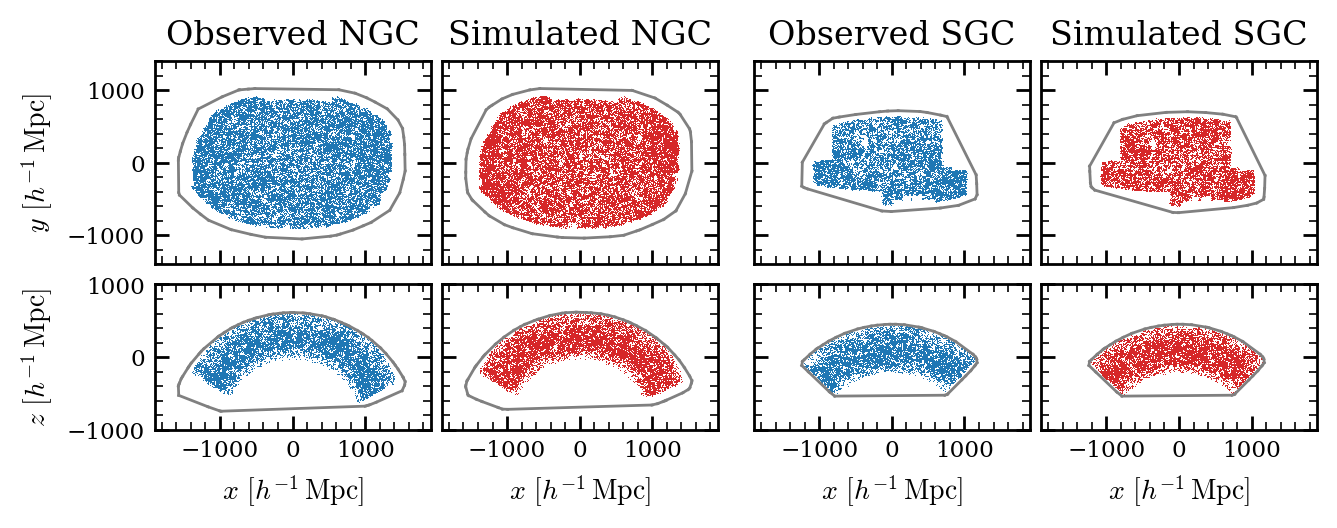

In [30]:
from scipy.spatial import ConvexHull


def plot_convex_hull(xy, ax, **kwargs):
    hull = ConvexHull(xy)
    for simplex in hull.simplices:
        ax.plot(xy[simplex, 0], xy[simplex, 1], **kwargs)


f, axs = plt.subplots(
    2, 5, figsize=(7.5, 2.5),
    sharex=True, sharey=False,
    gridspec_kw=dict(height_ratios=[1400, 1000], width_ratios=[1, 1, 0.05, 1, 1],
                     hspace=0.02, wspace=0.05)
)
axlim = [1900, 1400, 1000]

for ax in axs.flatten():
    ax.set_aspect('equal')
    # ax.grid()

dz = (0.58, 0.6)
ddec = 33, 35

# plot face-on
ax = axs[0, 0]
m = (nrdz[:, 2] > dz[0]) & (nrdz[:, 2] < dz[1])
ax.plot(nxyz[m, 0], nxyz[m, 1], ',',  c='C0', rasterized=True)
plot_convex_hull(nxyz[:, :2], ax, c='gray', lw=1, ls='-')
ax.set_xlim(-axlim[0], axlim[0])
ax.set_ylim(-axlim[1], axlim[1])
ax.set_title('Observed NGC')
ax.set(ylabel=r'$y$ $[h^{-1} \, \mathrm{Mpc}]$')
ax.set_aspect('equal')

# plot edge-on
ax = axs[1, 0]
m = (nrdz[:, 1] > ddec[0]) & (nrdz[:, 1] < ddec[1])
ax.plot(nxyz[m, 0], nxyz[m, 2], ',',  c='C0', rasterized=True)
plot_convex_hull(nxyz[:, [0, 2]], ax, c='gray', lw=1, ls='-')
ax.set_ylim(-axlim[2], axlim[2])
ax.set(xlabel=r'$x$ $[h^{-1} \, \mathrm{Mpc}]$',
       ylabel=r'$z$ $[h^{-1} \, \mathrm{Mpc}]$')
ax.set_aspect('equal')


# plot face-on
ax = axs[0, 1]
m = (ncrdz[:, 2] > dz[0]) & (ncrdz[:, 2] < dz[1])
ax.plot(ncxyz[m, 0], ncxyz[m, 1], ',',  c='C3', rasterized=True)
plot_convex_hull(ncxyz[:, :2], ax, c='gray', lw=1, ls='-')
ax.set_xlim(-axlim[0], axlim[0])
ax.set_ylim(-axlim[1], axlim[1])
ax.set_title('Simulated NGC')
ax.set_yticklabels([])
ax.set_aspect('equal')

# plot edge-on
ax = axs[1, 1]
m = (ncrdz[:, 1] > ddec[0]) & (ncrdz[:, 1] < ddec[1])
ax.plot(ncxyz[m, 0], ncxyz[m, 2], ',',  c='C3', rasterized=True)
plot_convex_hull(ncxyz[:, [0, 2]], ax, c='gray', lw=1, ls='-')
ax.set_ylim(-axlim[2], axlim[2])
ax.set_yticklabels([])
ax.set(xlabel=r'$x$ $[h^{-1} \, \mathrm{Mpc}]$')
ax.set_aspect('equal')

# remove empty axes
axs[0, 2].axis('off')
axs[1, 2].axis('off')


dz = (0.58, 0.6)
ddec = 0, 2

# plot face-on
ax = axs[0, 3]
m = (srdz[:, 2] > dz[0]) & (srdz[:, 2] < dz[1])
ax.plot(sxyz[m, 0], sxyz[m, 1], ',',  c='C0', rasterized=True)
plot_convex_hull(sxyz[:, :2], ax,  c='gray', lw=1, ls='-')
ax.set_xlim(-axlim[0], axlim[0])
ax.set_ylim(-axlim[1], axlim[1])
ax.set_title('Observed SGC')
ax.set_yticklabels([])
ax.set_aspect('equal')

# plot edge-on
ax = axs[1, 3]
m = (srdz[:, 1] > ddec[0]) & (srdz[:, 1] < ddec[1])
ax.plot(sxyz[m, 0], sxyz[m, 2], ',',  c='C0', rasterized=True)
plot_convex_hull(sxyz[:, [0, 2]], ax,  c='gray', lw=1, ls='-')
ax.set_ylim(-axlim[2], axlim[2])
ax.set(xlabel=r'$x$ $[h^{-1} \, \mathrm{Mpc}]$')
ax.set_yticklabels([])
ax.set_aspect('equal')


# plot face-on
ax = axs[0, 4]
m = (scrdz[:, 2] > dz[0]) & (scrdz[:, 2] < dz[1])
ax.plot(scxyz[m, 0], scxyz[m, 1], ',',  c='C3', rasterized=True)
plot_convex_hull(scxyz[:, :2], ax,  c='gray', lw=1, ls='-')
ax.set_xlim(-axlim[0], axlim[0])
ax.set_ylim(-axlim[1], axlim[1])
ax.set_title('Simulated SGC')
ax.set_yticklabels([])
ax.set_aspect('equal')

# plot edge-on
ax = axs[1, 4]
m = (scrdz[:, 1] > ddec[0]) & (scrdz[:, 1] < ddec[1])
ax.plot(scxyz[m, 0], scxyz[m, 2], ',',  c='C3', rasterized=True)
plot_convex_hull(sxyz[:, [0, 2]], ax,  c='gray', lw=1, ls='-')
ax.set_ylim(-axlim[2], axlim[2])
ax.set_yticklabels([])
ax.set(xlabel=r'$x$ $[h^{-1} \, \mathrm{Mpc}]$')
ax.set_aspect('equal')

f.align_ylabels(axs[:, 0])

f.savefig(join(imdir, 'cmass_comparison_comoving.pdf'),
          dpi=400, bbox_inches='tight')

## Scratch

In [8]:
# Find closest Quijote cosmology to fiducial
cosmolist = pd.read_csv(
    '/home/x-mho1/git/ltu-cmass/params/latin_hypercube_params.txt',
    sep=' ', header=None)
cosmolist = cosmolist.values

dcosmo = cosmolist[:-1] - cosmolist[-1]
dcosmo /= dcosmo.std(axis=0)
dcosmo = np.linalg.norm(dcosmo, axis=1)
# closest
lhid = np.argmin(dcosmo)
lhid, cosmolist[lhid], cosmolist[-1]

(2298,
 array([0.3799, 0.0477, 0.5904, 0.8636, 0.6147]),
 array([0.3874, 0.0507, 0.5905, 0.845 , 0.6515]))